# <font color='dodgerblue'> U-net for image segmentation

## <font color='orange'>Problem defining: 
### <font color='black'> Image segmentation and object detection have important applications in medical imaging (MRI), autonomous driving, and more. 
### <font color='black'>Here we apply U-net for semantic segmentation in the context of self-driving cars.

In [1]:
import numpy as np
import pandas as pd
import imageio
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

<a class="anchor" id="2" name="2"></a>
## **1. Load, list paths**

In [2]:
image_path = ["../input/lyft-udacity-challenge/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B', 'C', 'D', 'E']]
mask_path = ["../input/lyft-udacity-challenge/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B', 'C', 'D', 'E']]

In [3]:
def list_image_paths(directory_paths):
    image_paths = []
    for directory in range(len(directory_paths)):
        image_filenames = os.listdir(directory_paths[directory])
        for image_filename in image_filenames:
            image_paths.append(directory_paths[directory] + image_filename)
    return image_paths

In [4]:
image_paths = list_image_paths(image_path) 
mask_paths = list_image_paths(mask_path)
number_of_images, number_of_masks = len(image_paths), len(mask_paths)
print(f"1. There are {number_of_images} images and {number_of_masks} masks in our dataset")
print(f"2. An example of an image path is : \n {image_paths[0]}")
print(f"3. An example of a mask path is: \n {mask_paths[0]}")


1. There are 5000 images and 5000 masks in our dataset
2. An example of an image path is: 
 ../input/lyft-udacity-challenge/dataA/dataA/CameraRGB/F6-50.png
3. An example of a mask path is: 
 ../input/lyft-udacity-challenge/dataA/dataA/CameraSeg/F6-50.png


# 2. Preview

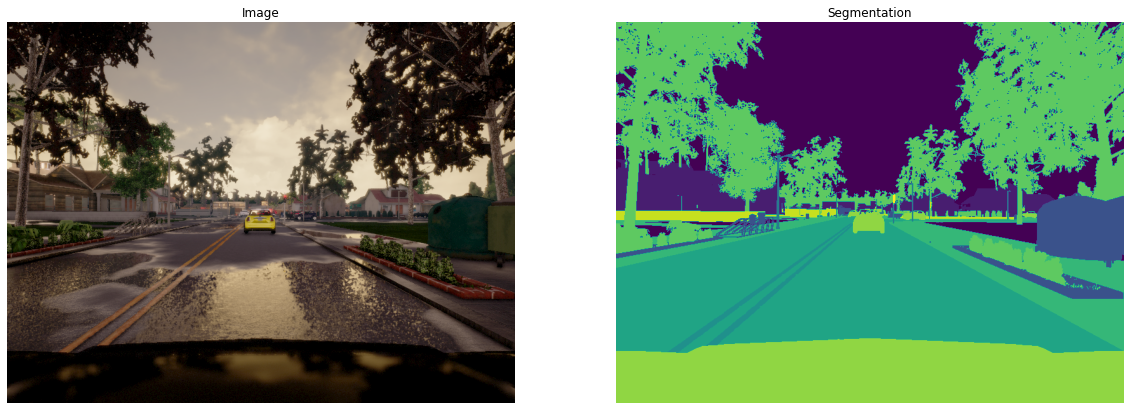

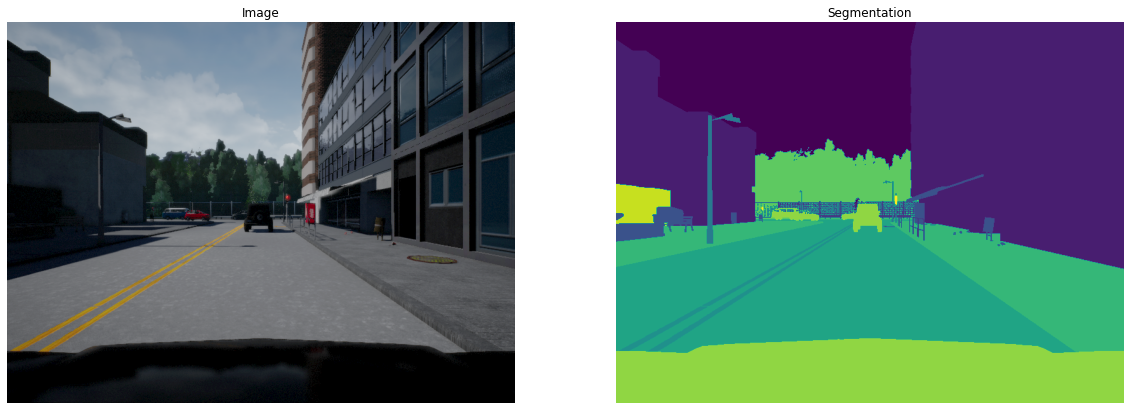

In [5]:
import random
number_of_samples = len(image_paths)

for i in range(2):
    N = random.randint(0, number_of_samples - 1)

    img = imageio.imread(image_paths[N])
    mask = imageio.imread(mask_paths[N])
    mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

    fig, arr = plt.subplots(1, 2, figsize=(20, 8))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(mask)
    arr[1].set_title('Segmentation')
    arr[1].axis("off")    

# 3. Split into training, validation, and test

In [6]:
# First split the image paths into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, train_size=0.8, random_state=0)

# Keep part of the validation set as test set
validation_image_paths, test_image_paths, validation_mask_paths, test_mask_paths = train_test_split(val_image_paths, val_mask_paths, train_size = 0.80, random_state=0)

print(f'There are {len(train_image_paths)} images in the Training Set')
print(f'There are {len(validation_image_paths)} images in the Validation Set')
print(f'There are {len(test_image_paths)} images in the Test Set')

There are 4000 images in the Training Set
There are 800 images in the Validation Set
There are 200 images in the Test Set


# 4. Resize

In [7]:
def read_image(image_path, mask_path):
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (256, 256), method='nearest')

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    
    return image, mask

#### A function to load images and masks

In [8]:
def data_generator(image_paths, mask_paths, buffer_size, batch_size):
    
    image_list = tf.constant(image_paths) 
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)
    
    return dataset

In [9]:
batch_size = 32
buffer_size = 500

train_dataset = data_generator(train_image_paths, train_mask_paths, buffer_size, batch_size)
validation_dataset = data_generator(validation_image_paths, validation_mask_paths, buffer_size, batch_size)
test_dataset = data_generator(test_image_paths, test_mask_paths, buffer_size, batch_size)

<a class="anchor" id="3" name="3"></a>
## **5. Model and Training**

#### The U-Net architecture consists of:

**1. Contracting path (Encoder containing downsampling steps)**:

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels. 

In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

During the contracting process, convolution outputs are stored in a separate variable before size reduction (pooling of features). This is passed to the expanding blocks during the decoding process as feature map.


**2. Expanding path (Decoder containing upsampling steps)**:

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually. 

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution or upsampling). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU.


**3. Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total. 
<center><img src="https://i.ibb.co/0287bZ1/U-Net.webp" alt="U-Net" border="0"></center>




To design our model, we will carry out the following steps
1. Define a function for an encoding block. The function will return the next layer output and the skip connection output for the corresponding block in the model
2. Define a function for a decoding block. This function will merge the skip-connection input with the previous layer, process it, and return an output
3. Develop a model using both the encoding and decoding blocks output

# Encoder

In [10]:
def encoding_block(inputs, filters, dropout_probability=0, max_pooling=True):

    """
    Convolutional encoding/downsampling block
    
    Arguments:
        inputs -- Input tensor
        filters -- Number of filters for the convolutional layers
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection inputs 
    """
    
    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(inputs)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)

    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)

    skip_connection = C  # Set aside residual
    
    # if max_pooling is True, add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(C)        
    else:
        next_layer = C
            
    return next_layer, skip_connection

# Decoder

In [11]:
def decoding_block(inputs, skip_connection_input, filters):
    """
    Convolutional decoding/upsampling block
    
    Arguments:
        inputs -- Input tensor from previous layer
        skip_connection_input -- Input tensor from previous skip layer
        filters -- Number of filters for the convolutional layers
    Returns: 
        C -- Tensor output
    """

    CT = Conv2DTranspose(filters, 3, strides=(2,2), padding="same", kernel_initializer="he_normal")(inputs)
    
    residual_connection = concatenate([CT, skip_connection_input], axis=3)

    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(residual_connection)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)
    
    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)
    
  
    return C

# U-net

In [12]:
def unet_model(input_size, filters, n_classes):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
        
    # Contracting Path (encoding)
    C1, S1 = encoding_block(inputs, filters, max_pooling=True)
    C2, S2 = encoding_block(C1, filters * 2, max_pooling=True)
    C3, S3 = encoding_block(C2, filters * 4, max_pooling=True)
    C4, S4 = encoding_block(C3, filters * 8, max_pooling=True)
    
    C5, S5 = encoding_block(C4, filters * 16, max_pooling=False)
    
    # Expanding Path (decoding)
    U6 = decoding_block(C5, S4, filters * 8)
    U7 = decoding_block(U6, S3,  filters * 4)
    U8 = decoding_block(U7, S2,  filters = filters * 2)
    U9 = decoding_block(U8, S1,  filters = filters)

    C10 = Conv2D(filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(U9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    C11 = Conv2D(filters = n_classes, kernel_size = (1,1), activation='sigmoid', padding='same')(C10)
    
    model = Model(inputs=inputs, outputs=C11)

    return model

# Model Summary

In [13]:
img_height = 256
img_width = 256
num_channels = 3
filters = 32
n_classes = 13

model = unet_model((img_height, img_width, num_channels), filters=32, n_classes=23)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

<a class="anchor" id="3-2" name="3-2"></a>
# Training 
### (Epoch=30, batch 32, min_lr = 2e-6, patience=20)

In [14]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
batch_size = 32
epochs = 30

In [15]:
history = model.fit(train_dataset, 
                    validation_data = validation_dataset, 
                    epochs = epochs, 
                    verbose=1, 
                    callbacks = [callback, reduce_lr], 
                    batch_size = batch_size, 
                    shuffle = True)

Epoch 1/30
125/125 [==============================] - 191s 1s/step - loss: 1.2576 - accuracy: 0.6812 - val_loss: 3.5124 - val_accuracy: 0.5221
Epoch 2/30
125/125 [==============================] - 52s 419ms/step - loss: 0.2380 - accuracy: 0.9280 - val_loss: 1.7725 - val_accuracy: 0.6590
Epoch 3/30
125/125 [==============================] - 53s 421ms/step - loss: 0.1743 - accuracy: 0.9460 - val_loss: 0.3357 - val_accuracy: 0.9052
Epoch 4/30
125/125 [==============================] - 53s 420ms/step - loss: 0.1451 - accuracy: 0.9541 - val_loss: 0.1467 - val_accuracy: 0.9540
Epoch 5/30
125/125 [==============================] - 53s 421ms/step - loss: 0.1189 - accuracy: 0.9617 - val_loss: 0.1175 - val_accuracy: 0.9621
Epoch 6/30
125/125 [==============================] - 53s 421ms/step - loss: 0.1167 - accuracy: 0.9623 - val_loss: 0.9866 - val_accuracy: 0.8404
Epoch 7/30
125/125 [==============================] - 53s 420ms/step - loss: 0.1308 - accuracy: 0.9583 - val_loss: 0.1050 - val_accu

# Accuracy vs Epoch

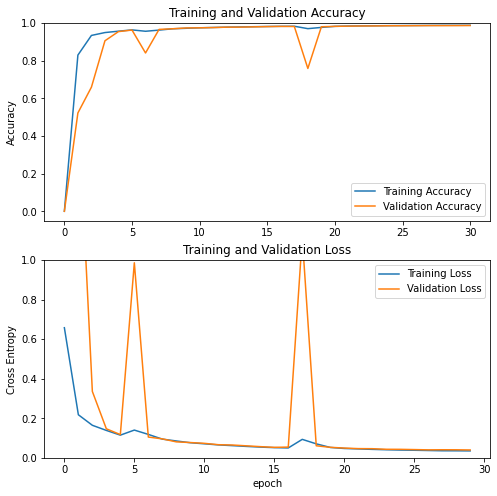

In [16]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
model.save('carla-image-segmentation-model.h5')

In [18]:
train_loss, train_accuracy = model.evaluate(train_dataset, batch_size = 32)
validation_loss, validation_accuracy = model.evaluate(validation_dataset, batch_size = 32)
test_loss, test_accuracy = model.evaluate(test_dataset, batch_size = 32)

7/7 [==============================] - 7s 186ms/step - loss: 0.0420 - accuracy: 0.9854


In [19]:
print(f'Model Accuracy on the Training Dataset: {round(train_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Validation Dataset: {round(validation_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Test Dataset: {round(test_accuracy * 100, 2)}%')

Model Accuracy on the Training Dataset: 98.77%
Model Accuracy on the Validation Dataset: 98.63%
Model Accuracy on the Test Dataset: 98.54%


<a class="anchor" id="4" name="4"></a>
## Classification Metrics

recall,precision, specificity, true detection rate (TDR), Intersection over Union (IoU), and F1-score as supplementary metrics to evaluate our model performance. These metrics were computed by identifying the variables true positive (TP), true negative (TN), false positive (FP), and false-negative (FN) by calculating the confusion matrix between the predicted segmentations and the ground truth segmentations. 

1. Precision = TP/(TP + FP)
2. Recall/Sensitivity = TP/(TP + FN)
3. Specificity = TN/(TN + FP)
4. True Detection Rate (TDR) = 1 - (FN/(TP + FN))
5. Intersection over Union (IoU)/Jaccard Similarity  = TP/(TP + FP + FN)
6. F1-score(JS)/Dice coefficient = 2 * ((Precision * Recall)/(Precision + Recall))

<br/>

To carry out these evaluations, we will:
1. Create segmentations/masks of images in our dataset
2. Evaluate predicted segmentations


In [20]:
def create_mask(dataset, model):
    true_masks, predicted_masks = [], []
    for images, masks in dataset:
        pred_masks = model.predict(images)
        pred_masks = tf.expand_dims(tf.argmax(pred_masks, axis=-1), axis=-1)
        true_masks.extend(masks)
        predicted_masks.extend(pred_masks)
        
    true_masks = np.array(true_masks)
    predicted_masks = np.array(predicted_masks)
        
    return true_masks, predicted_masks    

In [21]:
true_train_masks, predicted_train_masks = create_mask(train_dataset, model)
true_validation_masks, predicted_validation_masks = create_mask(validation_dataset, model)
true_test_masks, predicted_test_masks = create_mask(test_dataset, model)

### **Evaluate Predictions**

In [22]:
def evaluate_model(true_masks, predicted_masks, n_classes, smooth = 1e-6):
    
    """
    Evaluates semantic segmentation model
    
    Argument:
        true_masks: ground truth segmentations
        predicted_masks: predicted segmentations
        n_classes: number of segmentation classes
        smooth: a minute float digit added to denominators to avoid error from a zero division
    
    Returns:
        class_wise_evaluations: a dictionary containing evaluation metric 
                                outputs the for each segmentation class 
        overall_evaluations: a dictionary containing evaluation metric 
                             outputs the for all segmentation classes
        """
    # Create empty lists to store evaluation metric outputs
    class_wise_true_positives, class_wise_true_negatives = [],[]
    class_wise_false_positives, class_wise_false_negatives = [],[]
    class_wise_precisions, class_wise_recalls = [],[] 
    class_wise_specificities, class_wise_ious = [],[] 
    class_wise_tdrs, class_wise_f1_scores = [],[]
    classes = []
            
    for clas in range(n_classes):
        true_positives, true_negatives, false_positives, false_negatives = 0,0,0,0
        precisions, recalls, specificities, ious, f1_scores, tdrs = 0,0,0,0,0,0        
        
        number_of_masks = true_masks.shape[0]
        
        for mask_id in range(number_of_masks):
            true_positive = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]==clas))
            true_negative = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]!=clas))
            false_positive = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]==clas))
            false_negative = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]!=clas))
            
            true_positives += true_positive
            true_negatives += true_negative
            false_positives += false_positive
            false_negatives += false_negative

        recall = round(true_positives/(true_positives + false_negatives + smooth), 2)
        precision = round(true_positives/(true_positives + false_positives + smooth), 2)
        specificity = round(true_negatives/(true_negatives + false_positives + smooth), 2)
        tdr = round((1 - (false_negatives/(true_positives + false_negatives + smooth))), 2)
        iou = round(true_positives/(true_positives + false_negatives + false_positives + smooth), 2)
        f1_score = round((2 * precision * recall)/(precision + recall + smooth), 2)
        
        class_wise_true_positives.append(true_positives)
        class_wise_true_negatives.append(true_negatives)
        class_wise_false_positives.append(false_positives)
        class_wise_false_negatives.append(false_negatives)
        class_wise_recalls.append(recall)
        class_wise_precisions.append(precision)
        class_wise_specificities.append(specificity)
        class_wise_ious.append(iou)
        class_wise_tdrs.append(tdr)
        class_wise_f1_scores.append(f1_score)
        classes.append("Class " + str(clas+1))
        # class_wise_pixel_accuracies.append(pixel_accuracy)
        
    total_true_positives = np.sum(class_wise_true_positives)
    total_true_negatives = np.sum(class_wise_true_negatives)
    total_false_positives = np.sum(class_wise_false_positives)
    total_false_negatives = np.sum(class_wise_false_negatives)
    mean_recall = round(np.average(np.array(class_wise_recalls)), 2)
    mean_precision = round(np.average(np.array(class_wise_precisions)), 2)
    mean_specificity = round(np.average(np.array(class_wise_specificities)), 2)
    mean_iou = round(np.average(np.array(class_wise_ious)), 2)
    mean_tdr = round(np.average(np.array(class_wise_tdrs)), 2)
    mean_f1_score = round(np.average(np.array(class_wise_f1_scores)), 2)    
         
    class_wise_evaluations = {"Class": classes,
                              "True Positive Pixels": class_wise_true_positives,
                              "True Negative Pixels": class_wise_true_negatives,
                              "False Positive Pixels": class_wise_false_positives,
                              "False Negative Pixels": class_wise_false_negatives,
                              "Recall": class_wise_recalls,
                              "Precision": class_wise_precisions,
                              "Specificity": class_wise_specificities,
                              "IoU": class_wise_ious,
                              "TDR": class_wise_tdrs,
                              "F1-Score": class_wise_f1_scores}

    overall_evaluations = {"Class": "All Classes",
                        "True Positive Pixels": total_true_positives,
                        "True Negative Pixels": total_true_negatives,
                        "False Positive Pixels": total_false_positives,
                        "False Negative Pixels": total_false_negatives,
                        "Recall": mean_recall,
                        "Precision": mean_precision,
                        "Specificity": mean_specificity,
                        "IoU": mean_iou,
                        "TDR": mean_tdr,
                        "F1-Score": mean_f1_score}
    
    evaluations = {"Overall Evaluations": overall_evaluations, 
                   "Class-wise Evaluations": class_wise_evaluations}
    
    return evaluations

In [23]:
def show_evaluations(evaluations, 
                     metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1 Score"], 
                     class_list=None,
                     display_evaluations="All"):
    """
    Returns a pandas dataframe containing specified metrics
        
        Arguments:
            evaluations: evaluation output from the evaluate_model function
            metrics: a list containing one or more of the following metrics:
                     'True Positive', 'True Negative', 'False Positive', 'False Negative',
                     'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'
            display_evaluations: one of 'All' to display both overall and class-wise evaluations,
                                 'Overall' to display only the overall evaluations,
                                 'Class-wise' to display only the classwise evaluations.
            class_list: list or tuple containing names of segmentation class.
    """
    
    # Split evaluations into overall and class-wise evaluations
    overall_evaluations = evaluations["Overall Evaluations"]
    class_wise_evaluations = evaluations["Class-wise Evaluations"]
    
    # Validate list of metrics 
    for metric_id in range(len(metrics)):
        metric = metrics[metric_id]
        if metric not in overall_evaluations:
            raise ValueError("'metrics argument' not properly defined. "
                            "Kindly create a list containing one or more of the following metrics: "
                             "'True Positive', 'True Negative', 'False Positive', 'False Negative', "
                             "'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'") 
    
    # Check if class_list is none
    if class_list != None and all(isinstance(class_, str) for class_ in class_list):
        if len(class_list) == len(class_wise_evaluations["Class"]):
            class_list = [class_list]
        else:
            raise ValueError("class_list argument' not properly defined. " 
                             "List is either shorter or longer than segmentation classes") 
    else:
        class_list = [class_wise_evaluations["Class"]]                             
    
    # Extract data from the evaluations
    overall_data = [overall_evaluations["Class"]] + [overall_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))]
    classwise_data = class_list + [class_wise_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))]
    overall_data = np.array(overall_data).reshape(1,-1)
    classwise_data = np.array(classwise_data).transpose()
    
    # Determine the type of evaluation report to display
    if display_evaluations.lower() == "all":
        data = np.concatenate((overall_data, classwise_data), axis=0)
    elif display_evaluations.lower() == "overall":
        data = overall_data
    elif display_evaluations.lower() == "class-wise" or "classwise":
        data = classwise_data
    else:
        raise ValueError("Display argument are not properly defined."
                        "Kindly use 'All' to display both overall and class-wise evaluations."
                        "Use 'Overall' to display only the overall evaluations."
                        "Or use 'Class-wise' to display only the class-wise evaluations")

    
    # Create evaluation report as a pandas dataframe
    dataframe = pd.DataFrame(data)
    dataframe_titles = ["Class"] + metrics
    dataframe.columns = dataframe_titles
    # dataframe = dataframe.set_index(dataframe_titles[0], col_level=1)
    
    return dataframe

#### **Evaluate training**

In [24]:
model_evaluation_on_train_dataset = evaluate_model(true_train_masks, predicted_train_masks, n_classes=13)

show_evaluations(model_evaluation_on_train_dataset, 
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                 class_list=None, 
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.9,0.93,1.0,0.85,0.9,0.91
1,Class 1,0.99,0.99,1.0,0.99,0.99,0.99
2,Class 2,0.98,0.98,1.0,0.96,0.98,0.98
3,Class 3,0.89,0.85,1.0,0.77,0.89,0.87
4,Class 4,0.87,0.87,1.0,0.77,0.87,0.87
5,Class 5,0.33,0.78,1.0,0.3,0.33,0.46
6,Class 6,0.86,0.93,1.0,0.8,0.86,0.89
7,Class 7,0.98,0.99,1.0,0.97,0.98,0.98
8,Class 8,1.0,1.0,1.0,0.99,1.0,1.0
9,Class 9,0.97,0.99,1.0,0.96,0.97,0.98


#### **Evaluate validation**

In [25]:
model_evaluation_on_validation_dataset = evaluate_model(true_validation_masks, predicted_validation_masks, n_classes=13)

show_evaluations(model_evaluation_on_validation_dataset, 
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                 class_list=None, 
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.87,0.93,1.0,0.83,0.87,0.89
1,Class 1,0.99,0.99,1.0,0.99,0.99,0.99
2,Class 2,0.98,0.97,1.0,0.95,0.98,0.97
3,Class 3,0.88,0.84,1.0,0.75,0.88,0.86
4,Class 4,0.83,0.85,1.0,0.73,0.83,0.84
5,Class 5,0.27,0.81,1.0,0.25,0.27,0.4
6,Class 6,0.78,0.9,1.0,0.72,0.78,0.84
7,Class 7,0.98,0.99,1.0,0.97,0.98,0.98
8,Class 8,1.0,1.0,1.0,0.99,1.0,1.0
9,Class 9,0.97,0.98,1.0,0.96,0.97,0.97


#### **Evaluate test**

In [26]:
model_evaluation_on_test_dataset = evaluate_model(true_test_masks, predicted_test_masks, n_classes=13)

show_evaluations(model_evaluation_on_test_dataset, 
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                 class_list=None, 
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.9,0.93,1.0,0.85,0.9,0.91
1,Class 1,0.99,0.99,1.0,0.99,0.99,0.99
2,Class 2,0.98,0.97,1.0,0.95,0.98,0.97
3,Class 3,0.89,0.86,1.0,0.78,0.89,0.87
4,Class 4,0.84,0.85,1.0,0.73,0.84,0.84
5,Class 5,0.53,0.78,1.0,0.46,0.53,0.63
6,Class 6,0.79,0.9,1.0,0.73,0.79,0.84
7,Class 7,0.98,0.99,1.0,0.96,0.98,0.98
8,Class 8,1.0,1.0,1.0,0.99,1.0,1.0
9,Class 9,0.97,0.98,1.0,0.95,0.97,0.97


## **6. Prediction**

1. Load our model
2. Define a function to create new masks using our model
3. Define a function to display outputs of this process: an input image, its true mask, and its predicted mask.
4. Define a function to select images from a specified dataset and return the images, their true masks and their predicted masks.

In [27]:
model = load_model('carla-image-segmentation-model.h5')

##### A function to create new masks

In [28]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    
    return pred_mask[0]

##### A function to display outputs

In [29]:
def display(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

##### **A function to select images from a specified dataset and return the images, their true masks and their predicted masks** 

In [30]:
def show_predictions(dataset, num):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

<a class="anchor" id="5-2" name="5-2"></a>
### **training set output**

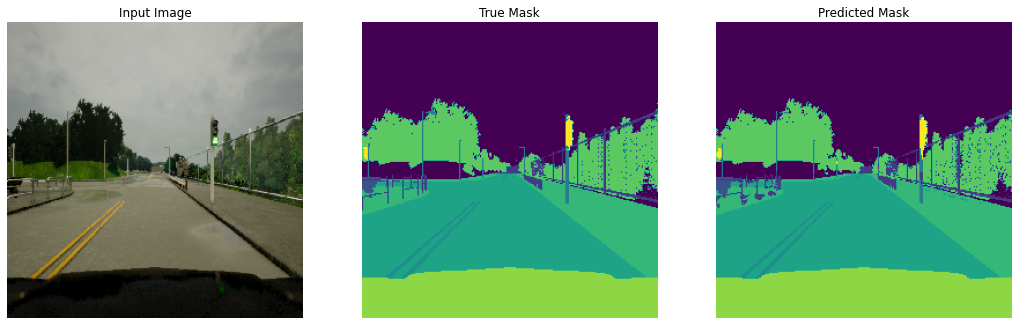

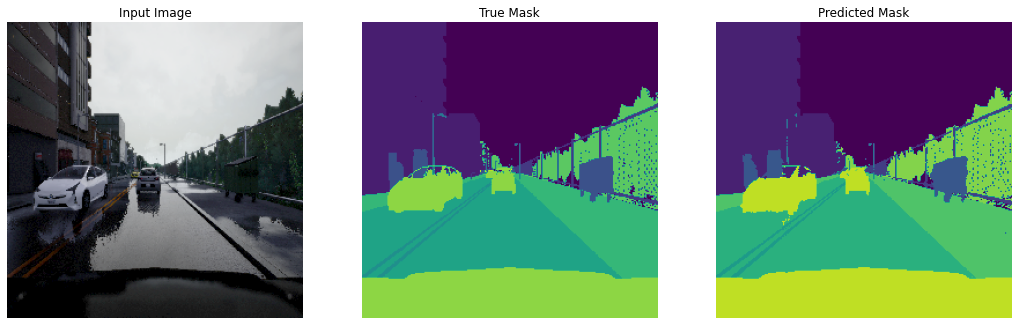

In [31]:
show_predictions(train_dataset, 2)

<a class="anchor" id="5-3" name="5-3"></a>
### **validation set output**

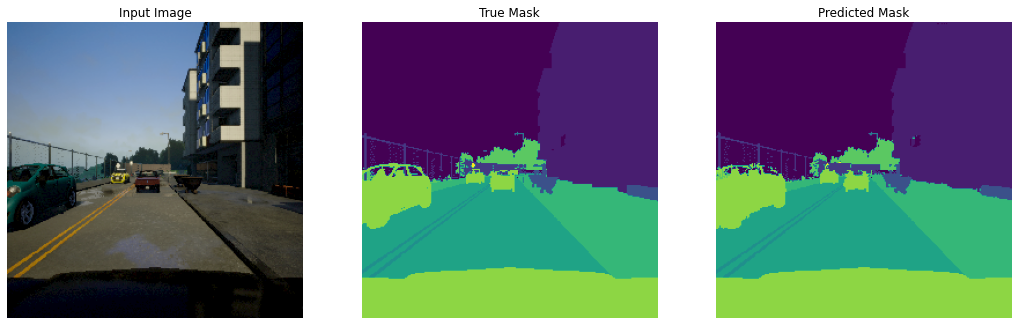

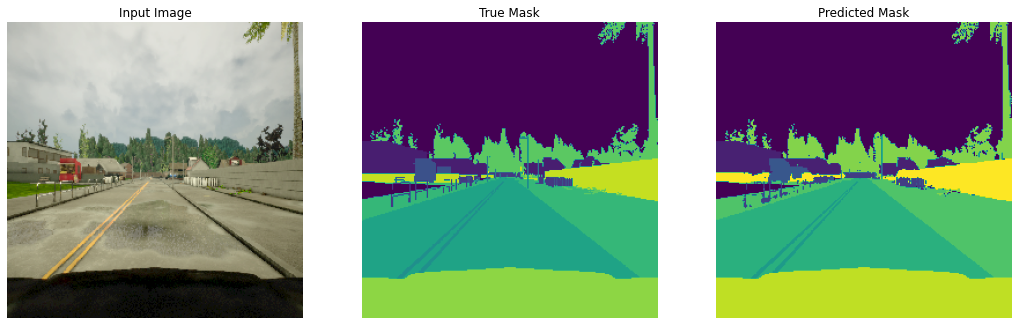

In [32]:
show_predictions(validation_dataset, 2)

<a class="anchor" id="5-4" name="5-4"></a>
### ** test set output**

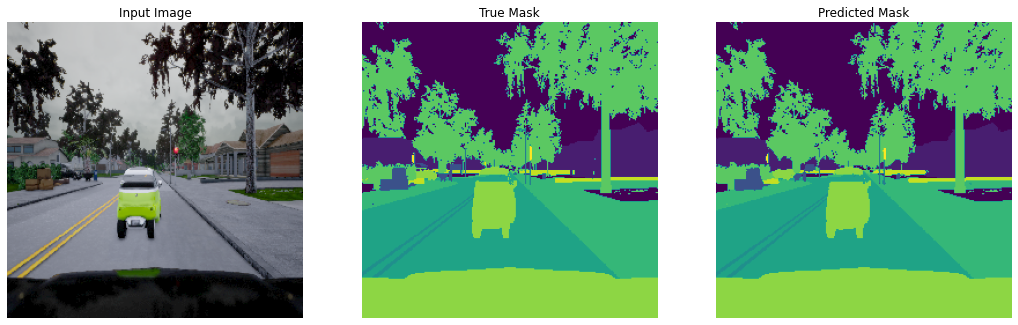

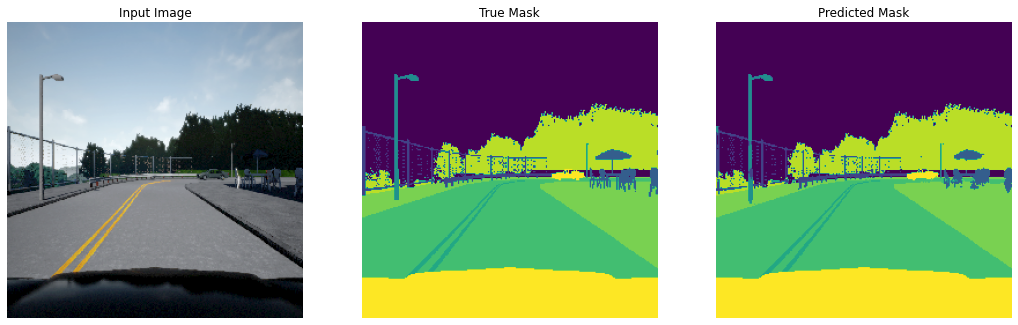

In [33]:
show_predictions(test_dataset, 2)

# Further Tuning of the U-net Model

### Epoch and batch (smaller)

In [34]:
img_height = 256
img_width = 256
num_channels = 3
model = unet_model((img_height, img_width, num_channels), filters=32, n_classes=23)


model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
batch_size = 10#32
epochs = 10#30

history = model.fit(train_dataset, 
                    validation_data = validation_dataset, 
                    epochs = epochs, 
                    verbose=1, 
                    callbacks = [callback, reduce_lr], 
                    batch_size = batch_size, 
                    shuffle = True)

Epoch 1/10
125/125 [==============================] - 55s 423ms/step - loss: 1.1380 - accuracy: 0.7117 - val_loss: 1.6071 - val_accuracy: 0.6423
Epoch 2/10
125/125 [==============================] - 53s 420ms/step - loss: 0.2186 - accuracy: 0.9344 - val_loss: 0.8589 - val_accuracy: 0.7862
Epoch 3/10
125/125 [==============================] - 52s 419ms/step - loss: 0.1604 - accuracy: 0.9503 - val_loss: 0.6300 - val_accuracy: 0.8357
Epoch 4/10
125/125 [==============================] - 52s 420ms/step - loss: 0.1329 - accuracy: 0.9578 - val_loss: 0.2581 - val_accuracy: 0.9163
Epoch 5/10
125/125 [==============================] - 52s 420ms/step - loss: 0.1107 - accuracy: 0.9643 - val_loss: 0.1222 - val_accuracy: 0.9610
Epoch 6/10
125/125 [==============================] - 52s 420ms/step - loss: 0.0956 - accuracy: 0.9686 - val_loss: 0.0935 - val_accuracy: 0.9691
Epoch 7/10
125/125 [==============================] - 52s 419ms/step - loss: 0.0871 - accuracy: 0.9708 - val_loss: 0.0939 - val_ac

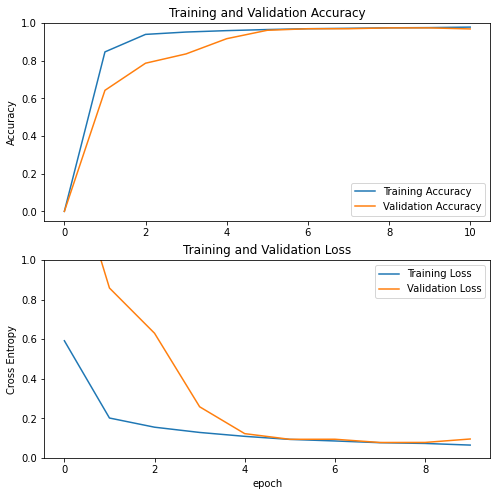

In [35]:

acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Learning rate (faster)

In [36]:
img_height = 256
img_width = 256
num_channels = 3
model = unet_model((img_height, img_width, num_channels), filters=32, n_classes=23)


model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-5)#2e-6)
batch_size = 10#32
epochs = 10#30

history = model.fit(train_dataset, 
                    validation_data = validation_dataset, 
                    epochs = epochs, 
                    verbose=1, 
                    callbacks = [callback, reduce_lr], 
                    batch_size = batch_size, 
                    shuffle = True)

Epoch 1/10
125/125 [==============================] - 55s 424ms/step - loss: 1.1913 - accuracy: 0.6852 - val_loss: 3.9032 - val_accuracy: 0.5643
Epoch 2/10
125/125 [==============================] - 52s 420ms/step - loss: 0.2418 - accuracy: 0.9277 - val_loss: 3.7020 - val_accuracy: 0.4656
Epoch 3/10
125/125 [==============================] - 52s 419ms/step - loss: 0.1739 - accuracy: 0.9460 - val_loss: 0.6026 - val_accuracy: 0.8573
Epoch 4/10
125/125 [==============================] - 52s 420ms/step - loss: 0.1427 - accuracy: 0.9549 - val_loss: 0.1992 - val_accuracy: 0.9365
Epoch 5/10
125/125 [==============================] - 52s 419ms/step - loss: 0.1219 - accuracy: 0.9609 - val_loss: 0.1197 - val_accuracy: 0.9614
Epoch 6/10
125/125 [==============================] - 52s 420ms/step - loss: 0.1050 - accuracy: 0.9657 - val_loss: 0.1161 - val_accuracy: 0.9619
Epoch 7/10
125/125 [==============================] - 53s 421ms/step - loss: 0.0943 - accuracy: 0.9688 - val_loss: 0.1003 - val_ac

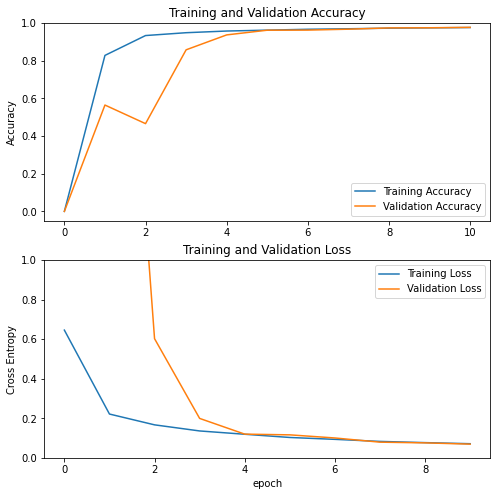

In [37]:

acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
model_evaluation_on_train_dataset = evaluate_model(true_train_masks, predicted_train_masks, n_classes=13)

show_evaluations(model_evaluation_on_train_dataset, 
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                 class_list=None, 
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.9,0.93,1.0,0.85,0.9,0.91
1,Class 1,0.99,0.99,1.0,0.99,0.99,0.99
2,Class 2,0.98,0.98,1.0,0.96,0.98,0.98
3,Class 3,0.89,0.85,1.0,0.77,0.89,0.87
4,Class 4,0.87,0.87,1.0,0.77,0.87,0.87
5,Class 5,0.33,0.78,1.0,0.3,0.33,0.46
6,Class 6,0.86,0.93,1.0,0.8,0.86,0.89
7,Class 7,0.98,0.99,1.0,0.97,0.98,0.98
8,Class 8,1.0,1.0,1.0,0.99,1.0,1.0
9,Class 9,0.97,0.99,1.0,0.96,0.97,0.98


In [39]:
model_evaluation_on_validation_dataset = evaluate_model(true_validation_masks, predicted_validation_masks, n_classes=13)

show_evaluations(model_evaluation_on_validation_dataset, 
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                 class_list=None, 
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.87,0.93,1.0,0.83,0.87,0.89
1,Class 1,0.99,0.99,1.0,0.99,0.99,0.99
2,Class 2,0.98,0.97,1.0,0.95,0.98,0.97
3,Class 3,0.88,0.84,1.0,0.75,0.88,0.86
4,Class 4,0.83,0.85,1.0,0.73,0.83,0.84
5,Class 5,0.27,0.81,1.0,0.25,0.27,0.4
6,Class 6,0.78,0.9,1.0,0.72,0.78,0.84
7,Class 7,0.98,0.99,1.0,0.97,0.98,0.98
8,Class 8,1.0,1.0,1.0,0.99,1.0,1.0
9,Class 9,0.97,0.98,1.0,0.96,0.97,0.97


### filters 32->16

In [40]:
img_height = 256
img_width = 256
num_channels = 3
model = unet_model((img_height, img_width, num_channels), filters=16, n_classes=23)


model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
batch_size = 10#32
epochs = 10#30

history = model.fit(train_dataset, 
                    validation_data = validation_dataset, 
                    epochs = epochs, 
                    verbose=1, 
                    callbacks = [callback, reduce_lr], 
                    batch_size = batch_size, 
                    shuffle = True)

Epoch 1/10
125/125 [==============================] - 32s 233ms/step - loss: 1.9470 - accuracy: 0.4471 - val_loss: 2.5120 - val_accuracy: 0.5879
Epoch 2/10
125/125 [==============================] - 29s 229ms/step - loss: 0.3954 - accuracy: 0.8993 - val_loss: 1.9316 - val_accuracy: 0.5212
Epoch 3/10
125/125 [==============================] - 28s 228ms/step - loss: 0.2442 - accuracy: 0.9279 - val_loss: 0.5581 - val_accuracy: 0.8463
Epoch 4/10
125/125 [==============================] - 29s 228ms/step - loss: 0.1848 - accuracy: 0.9442 - val_loss: 0.2323 - val_accuracy: 0.9309
Epoch 5/10
125/125 [==============================] - 28s 228ms/step - loss: 0.1562 - accuracy: 0.9523 - val_loss: 0.1624 - val_accuracy: 0.9502
Epoch 6/10
125/125 [==============================] - 28s 228ms/step - loss: 0.1339 - accuracy: 0.9585 - val_loss: 0.1435 - val_accuracy: 0.9547
Epoch 7/10
125/125 [==============================] - 28s 228ms/step - loss: 0.1193 - accuracy: 0.9624 - val_loss: 0.1265 - val_ac

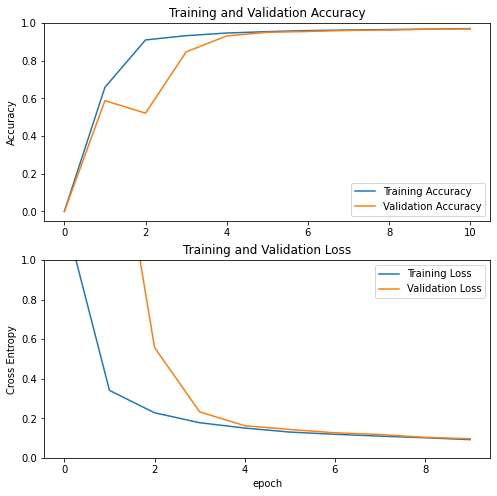

In [41]:

acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### n_classes 23->10

In [42]:
img_height = 256
img_width = 256
num_channels = 3
model = unet_model((img_height, img_width, num_channels), filters=32, n_classes=10)


model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
batch_size = 10#32
epochs = 10#30

history = model.fit(train_dataset, 
                    validation_data = validation_dataset, 
                    epochs = epochs, 
                    verbose=1, 
                    callbacks = [callback, reduce_lr], 
                    batch_size = batch_size, 
                    shuffle = True)

Epoch 1/10
125/125 [==============================] - 54s 415ms/step - loss: nan - accuracy: 0.3077 - val_loss: nan - val_accuracy: 0.3118
Epoch 2/10
125/125 [==============================] - 51s 412ms/step - loss: nan - accuracy: 0.3112 - val_loss: nan - val_accuracy: 0.3118
Epoch 3/10
125/125 [==============================] - 52s 412ms/step - loss: nan - accuracy: 0.3110 - val_loss: nan - val_accuracy: 0.3118
Epoch 4/10
125/125 [==============================] - 51s 412ms/step - loss: nan - accuracy: 0.3110 - val_loss: nan - val_accuracy: 0.3118
Epoch 5/10
125/125 [==============================] - 51s 412ms/step - loss: nan - accuracy: 0.3109 - val_loss: nan - val_accuracy: 0.3118
Epoch 6/10
125/125 [==============================] - 51s 412ms/step - loss: nan - accuracy: 0.3117 - val_loss: nan - val_accuracy: 0.3118

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/10
125/125 [==============================] - 51s 411ms/step - loss: nan - a

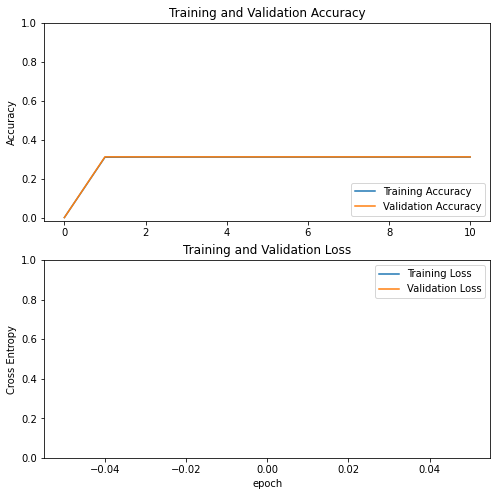

In [43]:

acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Patience 20-->10

In [44]:
img_height = 256
img_width = 256
num_channels = 3
model = unet_model((img_height, img_width, num_channels), filters=32, n_classes=23)


model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
batch_size = 10#32
epochs = 10#30

history = model.fit(train_dataset, 
                    validation_data = validation_dataset, 
                    epochs = epochs, 
                    verbose=1, 
                    callbacks = [callback, reduce_lr], 
                    batch_size = batch_size, 
                    shuffle = True)

Epoch 1/10
125/125 [==============================] - 55s 423ms/step - loss: 1.2597 - accuracy: 0.6694 - val_loss: 3.5552 - val_accuracy: 0.4217
Epoch 2/10
125/125 [==============================] - 53s 420ms/step - loss: 0.2486 - accuracy: 0.9252 - val_loss: 1.4464 - val_accuracy: 0.6851
Epoch 3/10
125/125 [==============================] - 52s 420ms/step - loss: 0.1852 - accuracy: 0.9427 - val_loss: 0.6420 - val_accuracy: 0.7901
Epoch 4/10
125/125 [==============================] - 53s 420ms/step - loss: 0.1428 - accuracy: 0.9549 - val_loss: 0.1963 - val_accuracy: 0.9367
Epoch 5/10
125/125 [==============================] - 52s 419ms/step - loss: 0.1165 - accuracy: 0.9624 - val_loss: 0.1145 - val_accuracy: 0.9628
Epoch 6/10
125/125 [==============================] - 52s 420ms/step - loss: 0.1060 - accuracy: 0.9653 - val_loss: 0.1158 - val_accuracy: 0.9614
Epoch 7/10
125/125 [==============================] - 52s 419ms/step - loss: 0.0955 - accuracy: 0.9683 - val_loss: 0.0911 - val_ac

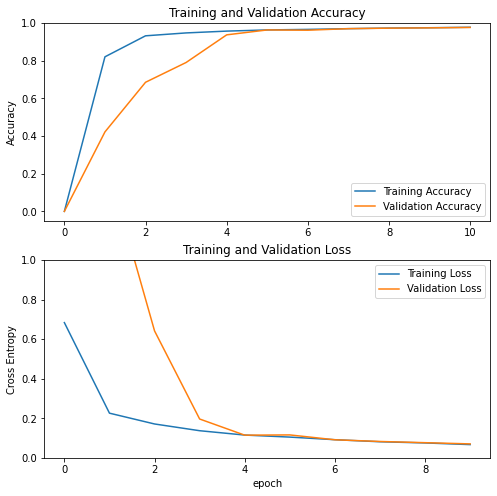

In [45]:

acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [46]:
model_evaluation_on_train_dataset = evaluate_model(true_train_masks, predicted_train_masks, n_classes=13)

show_evaluations(model_evaluation_on_train_dataset, 
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                 class_list=None, 
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.9,0.93,1.0,0.85,0.9,0.91
1,Class 1,0.99,0.99,1.0,0.99,0.99,0.99
2,Class 2,0.98,0.98,1.0,0.96,0.98,0.98
3,Class 3,0.89,0.85,1.0,0.77,0.89,0.87
4,Class 4,0.87,0.87,1.0,0.77,0.87,0.87
5,Class 5,0.33,0.78,1.0,0.3,0.33,0.46
6,Class 6,0.86,0.93,1.0,0.8,0.86,0.89
7,Class 7,0.98,0.99,1.0,0.97,0.98,0.98
8,Class 8,1.0,1.0,1.0,0.99,1.0,1.0
9,Class 9,0.97,0.99,1.0,0.96,0.97,0.98


In [47]:
model_evaluation_on_validation_dataset = evaluate_model(true_validation_masks, predicted_validation_masks, n_classes=13)

show_evaluations(model_evaluation_on_validation_dataset, 
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                 class_list=None, 
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.87,0.93,1.0,0.83,0.87,0.89
1,Class 1,0.99,0.99,1.0,0.99,0.99,0.99
2,Class 2,0.98,0.97,1.0,0.95,0.98,0.97
3,Class 3,0.88,0.84,1.0,0.75,0.88,0.86
4,Class 4,0.83,0.85,1.0,0.73,0.83,0.84
5,Class 5,0.27,0.81,1.0,0.25,0.27,0.4
6,Class 6,0.78,0.9,1.0,0.72,0.78,0.84
7,Class 7,0.98,0.99,1.0,0.97,0.98,0.98
8,Class 8,1.0,1.0,1.0,0.99,1.0,1.0
9,Class 9,0.97,0.98,1.0,0.96,0.97,0.97


# References:
https://www.kaggle.com/code/oluwatobiojekanmi/carla-image-semantic-segmentation-with-u-net

https://www.kaggle.com/code/aruchomu/yolo-v3-object-detection-in-tensorflow

https://www.kaggle.com/code/maartenvandevelde/object-detection-with-detectron2-pytorch

https://www.kaggle.com/code/pallavisinha12/object-detection

https://www.kaggle.com/code/rishabhiitbhu/unet-starter-kernel-pytorch-lb-0-88

https://www.kaggle.com/code/cdeotte/keras-unet-with-eda

https://www.kaggle.com/code/phoenigs/u-net-dropout-augmentation-stratification

https://www.kaggle.com/code/kmader/baseline-u-net-model-part-1
https://www.kaggle.com/code/xhlulu/severstal-simple-keras-u-net-boilerplate
https://www.kaggle.com/code/ateplyuk/pytorch-starter-u-net-resnet